 # Organizador Automático de Archivos con IA


### Claudia Ximena Paz Cendejas

Este script implementa un sistema de clasificación automática de archivos basado en técnicas avanzadas de inteligencia artificial (IA) y procesamiento de lenguaje natural (NLP). Su objetivo principal es leer el contenido textual de distintos tipos de archivos, entender su significado semántico mediante un modelo de lenguaje preentrenado, y agruparlos automáticamente en carpetas temáticas utilizando algoritmos de clustering no supervisado.

A diferencia de métodos tradicionales que organizan archivos solo por nombre o extensión, este sistema es capaz de interpretar el contenido real de cada documento —ya sea un texto, presentación, imagen escaneada, hoja de cálculo o notebook de código— y tomar decisiones de clasificación más profundas e informadas.

Gracias al uso de modelos de embeddings y la integración con modelos de lenguaje como GPT, el sistema no solo detecta patrones de similitud, sino que también puede asignar nombres temáticos a los grupos creados, corregir errores de clasificación y revisar casos ambiguos de forma automatizada. Esto permite transformar una carpeta caótica de archivos en una estructura coherente, organizada y fácil de explorar, facilitando la gestión documental en contextos académicos, profesionales o personales.

In [1]:
import os
import shutil
import csv
import json
import fitz 
from PIL import Image
import pytesseract
from docx import Document
from pptx import Presentation
from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import chromadb
from chromadb.config import Settings
from openai import OpenAI
import re
from sklearn.metrics import pairwise_distances_argmin_min
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from dotenv import load_dotenv



warnings.simplefilter(action='ignore', category=FutureWarning)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore", category=RuntimeWarning, module="threadpoolctl")


In [2]:
# ------------------ CONFIGURACION ------------------
RUTA_CARPETA = "./mis_archivos"

N_CLUSTERS = 5
ARCHIVO_LOG = "clasificacion_resultados.csv"

load_dotenv() 
API_KEY_OPENAI = os.getenv("OPENAI_API_KEY")

# Inicializar cliente ChromaDB y OpenAI
chroma_client = chromadb.Client(Settings(allow_reset=True))
collection = chroma_client.get_or_create_collection(name="archivos_organizados")
openai_client = OpenAI(api_key=API_KEY_OPENAI)


## Funciones 

En esta sección se definen todas las funciones fundamentales que permiten leer y analizar los archivos que se desean clasificar automáticamente usando IA.

- extraer_texto: se encarga de leer el contenido de los archivos, soportando múltiples formatos como PDF, DOCX, TXT, CSV, XLSX, imágenes (JPG/PNG), HTML, archivos de Jupyter (IPYNB) y presentaciones (PPTX). Para cada archivo, se extrae un fragmento representativo de texto.

- contextualizar_texto y evaluar_clusters_openai: generan mensajes para el modelo de lenguaje (como GPT-4), con el fin de analizar los clusters creados automáticamente, detectar errores y sugerir mejoras.

- extraer_sugerencias_de_reclasificacion, agente_juzgador, y aplicar_juicio_reclasificacion: automatizan la validación y modificación de la clasificación cuando se detectan inconsistencias en la agrupación semántica.

- extraer_nombres_clusters: analiza el texto generado por el modelo para asignar nombres más claros y significativos a cada cluster.

Estas funciones trabajan de manera coordinada para permitir que el sistema clasifique, evalúe y reorganice archivos en carpetas temáticas, basándose en su contenido semántico.


In [3]:
# ------------------ FUNCIONES ------------------
def extraer_texto(archivo):
    ext = archivo.lower().split('.')[-1]
    texto = ""
    try:
        if ext == "pdf":
            doc = fitz.open(archivo)
            texto = " ".join([page.get_text() for page in doc])

        elif ext == "docx":
            doc = Document(archivo)
            texto = " ".join([p.text for p in doc.paragraphs])

        elif ext in ["txt", "qmd"]:
            with open(archivo, 'r', encoding='utf-8', errors='ignore') as f:
                texto = f.read()

        elif ext == "csv":
            try:
                with open(archivo, 'r', encoding='utf-8', errors='ignore') as f:
                    lineas = []
                    for i, linea in enumerate(f):
                        if i >= 10:
                            break
                        lineas.append(linea.strip()[:300])  # corta cada línea por seguridad
                texto = "\n".join(lineas)
            except Exception as e:
                texto = f"[Error al leer CSV: {e}]"

        elif ext == "xlsx":
            try:
                import openpyxl
                wb = openpyxl.load_workbook(archivo, read_only=True, data_only=True)
                hoja = wb.active
                filas = []
                for i, row in enumerate(hoja.iter_rows(values_only=True)):
                    if i >= 10:
                        break
                    filas.append(", ".join([str(c) if c is not None else "" for c in row])[:300])
                texto = "\n".join(filas)
            except Exception as e:
                texto = f"[Error al leer XLSX: {e}]"

        elif ext == "xls":
            texto = "[Archivo XLS detectado. Requiere librerías específicas para leer contenido.]"

        elif ext in ["jpg", "jpeg", "png"]:
            texto = pytesseract.image_to_string(Image.open(archivo))

        elif ext == "html":
            with open(archivo, 'r', encoding='utf-8', errors='ignore') as f:
                soup = BeautifulSoup(f, 'html.parser')
                texto = soup.get_text()

        elif ext == "ipynb":
            with open(archivo, 'r', encoding='utf-8', errors='ignore') as f:
                data = json.load(f)
                texto = " ".join(
                    cell.get('source', '') if isinstance(cell.get('source', ''), str)
                    else " ".join(cell.get('source', ''))
                    for cell in data.get('cells', [])
                    if cell.get('cell_type') in ['markdown', 'code']
                )

        elif ext == "pptx":
            prs = Presentation(archivo)
            texto = " ".join(
                [shape.text for slide in prs.slides for shape in slide.shapes if hasattr(shape, "text")]
            )

    except Exception as e:
        print(f"❌ Error procesando {archivo}: {e}")
    return texto.strip()


def contextualizar_texto(texto, archivo):
    nombre = os.path.basename(archivo)
    return f"""
    Este es el contenido extraído del archivo llamado '{nombre}'.
    El contenido será analizado para clasificarlo por su tema principal.
    Lee cuidadosamente y considera el objetivo del documento.
    Contenido:
    {texto}
    """.strip()

def evaluar_clusters_openai(archivos, textos, etiquetas):
    resumen = ""
    for i in sorted(set(etiquetas)):
        docs = [f"Archivo: {os.path.basename(archivos[j])}\nContenido: {textos[j][:500]}..." for j in range(len(textos)) if etiquetas[j] == i]
        resumen += f"\n\n--- Cluster {i} ---\n" + "\n\n".join(docs)

    prompt = f"""
    A continuación te muestro documentos agrupados en distintos clusters por similitud semántica.
    Cada grupo contiene los nombres reales de los archivos y un fragmento de su contenido.

    Quiero que analices cada grupo y respondas con:
    - Tema principal del cluster.
    - Posibles errores de clasificación (usa exactamente el nombre de archivo si detectas alguno).
    - Propuestas de mejora o etiquetas más adecuadas. Una propuesta clara de nuevo nombre para cada cluster, con el formato exacto:  
      Cambiar el nombre del cluster a "Nombre_sugerido"

    ⚠️ Usa este formato si detectas errores:
    Archivo: \"nombre_del_archivo.ext\" debería ir en el cluster 1

    Evita usar \"cluster N\". Si no estás seguro, no propongas una reclasificación.

    Ahora, analiza los siguientes clusters:

    {resumen}
    """

    response = openai_client.chat.completions.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

def extraer_sugerencias_de_reclasificacion(analisis):
    sugerencias = []
    patron = r'Archivo: \"([^\"]+)\" debería ir en el cluster (\d+)'
    for linea in analisis.splitlines():
        match = re.search(patron, linea)
        if match:
            archivo = match.group(1)
            nuevo_cluster = int(match.group(2))
            sugerencias.append({"archivo": archivo, "nuevo_cluster": nuevo_cluster})
    return sugerencias

def extraer_temas_clusters_completo(analisis):
    bloques = re.split(r"-{3,}", analisis)
    temas = {}
    for bloque in bloques:
        match = re.search(r"cluster\s*(\d+)", bloque, re.IGNORECASE)
        if match:
            cluster = int(match.group(1))
            temas[cluster] = bloque.strip()
    return temas


def detectar_archivos_dudosos(archivos, textos):
    extensiones_dudosas = (".jpg", ".jpeg", ".png", ".pptx", ".afdesign", ".html", ".csv")
    return [(a, t) for a, t in zip(archivos, textos) if a.lower().endswith(extensiones_dudosas)]

def agente_juzgador(openai_client, archivo, texto, cluster_actual, resumen_clusters):
    prompt = f"""
Te mostraré el contenido de un archivo y el resumen de temas de los clusters existentes.

Archivo actual: \"{archivo}\"
Cluster asignado actualmente: {cluster_actual}

Contenido del archivo (recortado):
{texto[:1000]}

Resumen de clusters existentes:
{resumen_clusters}

¿Está bien clasificado el archivo o debería ir en otro cluster?

⚠️ Usa este formato si detectas errores:
Archivo: \"nombre_del_archivo.ext\" debería ir en el cluster 1

Evita usar \"cluster N\". Si no estás seguro, no propongas una reclasificación.

Justificación: ...
"""
    response = openai_client.chat.completions.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content.strip()

def aplicar_juicio_reclasificacion(decision, archivo_info, nombres_clusters):
    patron = r'Archivo: \"([^\"]+)\" debería ir en el cluster (\d+)'
    match = re.search(patron, decision)
    if match:
        archivo = match.group(1).lower()
        nuevo_cluster = int(match.group(2))

        if archivo in archivo_info:
            info = archivo_info[archivo]
            cluster_actual = info["cluster"]
            nombre_actual = nombres_clusters.get(cluster_actual, f"grupo_{cluster_actual}")
            nombre_nuevo = nombres_clusters.get(nuevo_cluster, f"grupo_{nuevo_cluster}")
            
            ruta_actual = os.path.join(RUTA_CARPETA, nombre_actual, archivo)
            nueva_ruta = os.path.join(RUTA_CARPETA, nombre_nuevo, archivo)

            if cluster_actual != nuevo_cluster and os.path.exists(ruta_actual):
                os.makedirs(os.path.dirname(nueva_ruta), exist_ok=True)
                shutil.move(ruta_actual, nueva_ruta)
                print(f"🔁 Reasignado por juicio: {archivo} → {nombre_nuevo}")
                info["cluster"] = nuevo_cluster


def extraer_nombres_clusters(analisis):
    """
    Extrae nombres sugeridos para los clusters desde el análisis textual de OpenAI.
    Soporta comillas curvas, guiones y formatos variados.
    """
    nombres = {}
    bloques = re.split(r"(?=\n\s*-+\s*Tema principal del Cluster\s+\d+)", analisis, flags=re.IGNORECASE)
    for bloque in bloques:
        match_cluster = re.search(r"Cluster\s+(\d+)", bloque, re.IGNORECASE)
        match_nombre = re.search(r'Cambiar el nombre del cluster a\s+[“\"”]?(.*?)[“\"”]?\s*$', bloque, re.IGNORECASE | re.MULTILINE)
        if match_cluster and match_nombre:
            cluster_id = int(match_cluster.group(1))
            nombre = match_nombre.group(1).strip()
            nombre = nombre.replace(" ", "_")
            nombre = re.sub(r"[^\w\-]", "", nombre)
            nombres[cluster_id] = nombre
    print("\n📛 Nombres extraídos:", nombres)
    return nombres



## Clasificación Inteligente de Archivos con IA Semántica
Esta sección representa el núcleo del sistema de clasificación automática de archivos mediante inteligencia artificial. El objetivo es agrupar documentos con base en su contenido, independientemente de su nombre o tipo de archivo, y asignarlos a carpetas temáticas relevantes. A continuación se detalla el proceso completo:

1. Carga y filtrado de archivos

El proceso inicia con la exploración de la carpeta base, en donde se encuentran los archivos sin clasificar. Se revisa cada archivo para confirmar que sea válido (no oculto ni vacío), y se intenta extraer su contenido de texto mediante la función extraer_texto(). Esta función es capaz de leer una gran variedad de formatos: PDF, DOCX, TXT, CSV, XLSX, imágenes con texto (usando OCR), HTML, Jupyter Notebooks, y presentaciones en PowerPoint.

Este paso es esencial porque permite que el sistema trabaje no solo con textos planos, sino con archivos reales utilizados en entornos profesionales y académicos. Solo se consideran "válidos" aquellos archivos que contienen texto significativo, lo cual asegura que las etapas posteriores trabajen sobre información útil y eviten errores por archivos vacíos o corruptos.

2. Generación de representaciones semánticas

Una vez extraído el contenido, cada archivo es transformado en una representación numérica llamada embedding semántico. Esta transformación se hace utilizando un modelo de lenguaje preentrenado (all-MiniLM-L6-v2) que convierte el texto en un vector de alta dimensión que captura su significado profundo.

Antes de codificar, se aplica un proceso de contextualización del texto, incluyendo el nombre del archivo para ayudar al modelo a entender mejor su posible función o propósito. Esto es especialmente útil cuando los textos son muy breves o ambiguos.

Este paso permite que el sistema comprenda el contenido más allá de simples palabras clave. Gracias a los embeddings, se pueden comparar documentos por su significado, aunque estén escritos con vocabularios diferentes.

3. Agrupamiento automático con K-Means

Los vectores semánticos generados son agrupados usando el algoritmo KMeans, una técnica de clustering no supervisado. Esto significa que el sistema no necesita etiquetas ni categorías predefinidas: encuentra por sí mismo los patrones y agrupa los documentos similares entre sí.

El número de clusters (N_CLUSTERS) se puede ajustar según el tamaño o diversidad del conjunto. Cada archivo recibe una etiqueta de cluster numérica, que representa el grupo temático al que pertenece.

Este paso es clave porque automatiza la organización de grandes volúmenes de documentos, identificando subconjuntos temáticamente consistentes de forma rápida, sin intervención manual.

4. Evaluación semántica con GPT (OpenAI)

Aunque el clustering agrupa archivos por similitud matemática, no puede decirnos de qué trata cada grupo. Para ello, el sistema utiliza un modelo de lenguaje avanzado como GPT-4.

Se genera un resumen de los archivos en cada cluster (incluyendo fragmentos de texto y nombres de archivo) y se envía a GPT, quien responde con:

El tema principal del grupo
Sugerencias de archivos mal clasificados
Y una propuesta clara de nombre temático para cada cluster
Este paso convierte resultados abstractos en agrupaciones inteligibles y humanas, permitiendo entender y validar la organización obtenida.

5. Organización de archivos en carpetas temáticas

Una vez que cada cluster ha sido evaluado y renombrado por GPT, el sistema crea una carpeta para cada tema identificado. Luego, mueve automáticamente los archivos a la carpeta correspondiente según el resultado del clustering.

Esto convierte un conjunto desorganizado de documentos en una estructura ordenada, donde cada archivo está dentro de una carpeta que refleja su tema real. Además, se guarda un registro (clasificacion_resultados.csv) que detalla la asignación de cada archivo, lo cual es útil para trazabilidad y auditoría.

6. Reclasificación automática por sugerencias del modelo

Durante el análisis de clusters, GPT puede detectar errores de agrupación: por ejemplo, un archivo de programación que terminó en el grupo de estadística. El sistema extrae esas sugerencias directamente del análisis y reubica los archivos de forma automática.

Este mecanismo garantiza una segunda capa de revisión, mejorando la precisión de la clasificación. Así, se aprovecha la capacidad de GPT para razonar sobre temas, más allá de la distancia vectorial usada por KMeans.

7. Activación de agentes "juzgadores"

Finalmente, se activa un mecanismo más fino para manejar los casos más inciertos: aquellos archivos más alejados del centro del cluster (outliers). Se calcula la distancia de cada archivo al centroide de su grupo, y se seleccionan los más lejanos.

Estos archivos son evaluados individualmente por un "agente juzgador", un modelo GPT que recibe:

El contenido del archivo
El nombre del cluster actual
Y un resumen de todos los clusters existentes
El agente analiza si el archivo está bien clasificado. Si no, justifica su decisión y el sistema lo reubica automáticamente. Esto permite una revisión semántica caso por caso, especialmente útil para archivos ambiguos o complejos.

In [4]:
# ------------------ CLASIFICACION ------------------
def clasificar_documentos():
    archivos = [os.path.join(RUTA_CARPETA, f) for f in os.listdir(RUTA_CARPETA)
                if os.path.isfile(os.path.join(RUTA_CARPETA, f)) and not f.startswith(".")]

    textos_extraidos = [(archivo, extraer_texto(archivo)) for archivo in archivos]
    archivos_validos = [(f, t) for f, t in textos_extraidos if t.strip() != ""]

    if len(archivos_validos) < N_CLUSTERS:
        print(f"⚠️ Solo hay {len(archivos_validos)} archivos con texto. Reduce N_CLUSTERS o agrega más archivos.")
        return

    archivos, textos = zip(*archivos_validos)
    textos_contextualizados = [contextualizar_texto(t, f) for f, t in zip(archivos, textos)]

    modelo = SentenceTransformer("all-MiniLM-L6-v2")
    vectores = modelo.encode(textos_contextualizados, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=False)

    collection.add(
        embeddings=list(vectores),
        documents=list(textos),
        ids=[f"id_{i}" for i in range(len(textos))],
        metadatas=[{"archivo": os.path.basename(arch)} for arch in archivos]
    )

    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0)
    etiquetas = kmeans.fit_predict(vectores)

    archivo_info = {
        os.path.basename(archivo).lower(): {
            "ruta_original": archivo,
            "cluster": etiquetas[idx],
            "idx": idx
        }
        for idx, archivo in enumerate(archivos)
    }

    print("\n🧠 Evaluando agrupaciones con OpenAI...")
    analisis = evaluar_clusters_openai(archivos, textos, etiquetas)
    print("\n📋 Análisis de agrupamiento generado por IA:\n")
    print(analisis)

    nombres_clusters = extraer_nombres_clusters(analisis)
    print("\n📛 Nombres extraídos:", nombres_clusters)

    for cluster_id in sorted(set(etiquetas)):
        nombre_cluster = nombres_clusters.get(cluster_id, f"grupo_{cluster_id}")
    
        if cluster_id not in nombres_clusters:
            print(f"⚠️ Nombre no encontrado para cluster {cluster_id}, usando nombre por defecto: {nombre_cluster}")

        os.makedirs(os.path.join(RUTA_CARPETA, nombre_cluster), exist_ok=True)


    with open(ARCHIVO_LOG, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(["archivo", "grupo"])
        for idx, archivo in enumerate(archivos):
            cluster_id = etiquetas[idx]
            nombre_cluster = nombres_clusters.get(cluster_id, f"grupo_{cluster_id}")
            destino = os.path.join(RUTA_CARPETA, nombre_cluster)
            shutil.move(archivo, os.path.join(destino, os.path.basename(archivo)))
            print(f"✅ {os.path.basename(archivo)} → {nombre_cluster}")
            writer.writerow([os.path.basename(archivo), nombre_cluster])

    sugerencias = extraer_sugerencias_de_reclasificacion(analisis)
    for sugerencia in sugerencias:
        archivo = sugerencia["archivo"].lower()
        nuevo_cluster = sugerencia["nuevo_cluster"]

        if archivo in archivo_info:
            info = archivo_info[archivo]
            cluster_actual = info["cluster"]
            ruta_actual = os.path.join(RUTA_CARPETA, nombres_clusters.get(cluster_actual, f"grupo_{cluster_actual}"), archivo)
            nueva_ruta = os.path.join(RUTA_CARPETA, nombres_clusters.get(nuevo_cluster, f"grupo_{nuevo_cluster}"), archivo)

            if cluster_actual != nuevo_cluster and os.path.exists(ruta_actual):
                os.makedirs(os.path.dirname(nueva_ruta), exist_ok=True)
                shutil.move(ruta_actual, nueva_ruta)
                print(f"🔁 Reclasificado: {archivo} → {nombres_clusters.get(nuevo_cluster, f'grupo_{nuevo_cluster}')}")
                info["cluster"] = nuevo_cluster

    print("\n⚖️ Activando agentes juzgadores para archivos dudosos...")

    # Archivos más alejados del centroide
    closest, distances = pairwise_distances_argmin_min(vectores, kmeans.cluster_centers_)
    df_distancias = pd.DataFrame({
        "archivo": [os.path.basename(a) for a in archivos],
        "cluster": etiquetas,
        "distancia": distances
    }).sort_values(by="distancia", ascending=False)

    archivos_dudosos = [
        (archivo_info[row.archivo.lower()]["ruta_original"], textos[archivo_info[row.archivo.lower()]["idx"]])
        for row in df_distancias.head(5).itertuples(index=False)
        if row.archivo.lower() in archivo_info
    ]

    resumen_clusters = "\n\n".join([f"--- Cluster {k} ---\n{v}" for k, v in extraer_temas_clusters_completo(analisis).items()])

    cluster_por_archivo = {
        os.path.basename(a).lower(): archivo_info[os.path.basename(a).lower()]["cluster"]
        for a in archivos
    }

    for archivo, texto in archivos_dudosos:
        nombre = os.path.basename(archivo).lower()
        cluster_actual = cluster_por_archivo.get(nombre, "Desconocido")
        try:
            decision = agente_juzgador(openai_client, nombre, texto, cluster_actual, resumen_clusters)
            print(f"\n🧐 Juicio para {nombre}:")
            print(decision)
            aplicar_juicio_reclasificacion(decision, archivo_info, nombres_clusters)
        except Exception as e:
            print(f"❌ Error juzgando {nombre}: {e}")



In [5]:
# ------------------ EJECUCION ------------------
if __name__ == "__main__":
    print("📂 Clasificando archivos con IA semántica + análisis GPT...")
    clasificar_documentos()
    print("\n🎉 Proceso completado con revisión de clusters.")


📂 Clasificando archivos con IA semántica + análisis GPT...

🧠 Evaluando agrupaciones con OpenAI...

📋 Análisis de agrupamiento generado por IA:

- Tema principal del cluster 0:
Estudios y análisis estadísticos, incluyendo trabajos, exámenes y aplicaciones diversas.

- Posibles errores de clasificación:
Archivo: "36716066-481a-4d22-a807-5631ea30764b.jpg" debería ir en el cluster 2 por ser más relevante con tareas de evaluación y examen. Archivo: "Machine Learning.pdf" podrías ir en el cluster 3 porque se enfoca en detalles de los modelos de Machine Learning en lugar de estadística directa.

- Propuestas de mejora o etiquetas más adecuadas:
Cambiar el nombre del cluster a "Análisis y Estadística"

- Tema principal del cluster 1:
Documentos de seguridad social.

- Posibles errores de clasificación:
No se detectan errores de clasificación.

- Propuestas de mejora o etiquetas más adecuadas:
Cambiar el nombre del cluster a "Documentos de Seguridad Social"

- Tema principal del cluster 2:
Via

## Visualización de Resultados

Para comprender mejor el comportamiento del sistema de clasificación, se presentan distintas visualizaciones que permiten explorar la calidad y características de los agrupamientos generados. Estas gráficas muestran:

- La distribución de archivos por tema, lo que permite ver si algunos clusters concentran más documentos que otros.
- La longitud del texto por grupo, útil para detectar variabilidad en el tipo de documentos (resúmenes, reportes, contratos, etc.).
- Nubes de palabras temáticas, que resaltan los conceptos más frecuentes en cada grupo y ayudan a validar si el tema asignado es coherente.

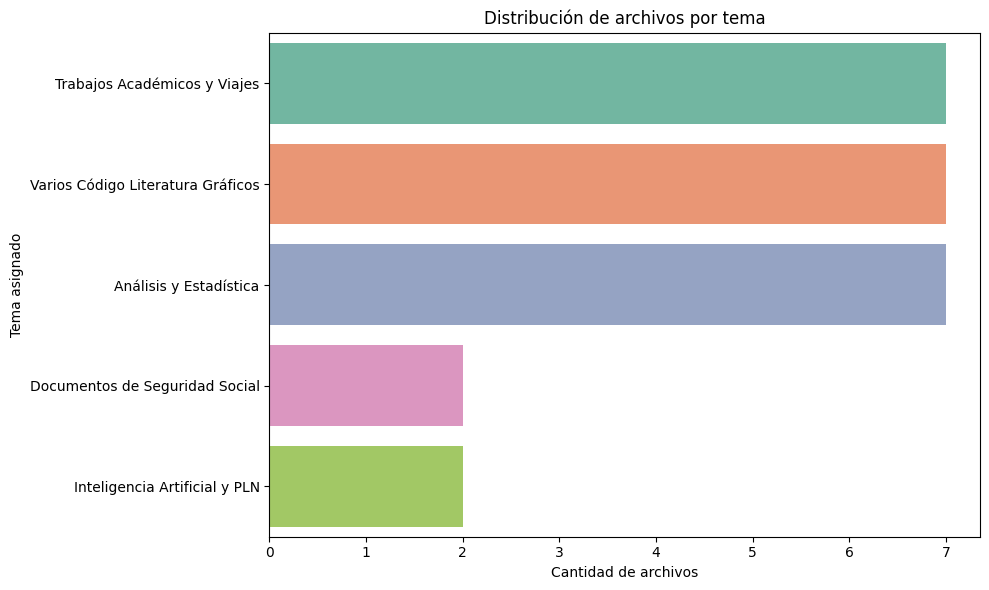

In [6]:
archivos_validos = []
etiquetas = []

for r in Path(RUTA_CARPETA).rglob("*"):
    if r.is_file() and r.name != ".DS_Store":
        nombre_carpeta = r.parent.name
        archivos_validos.append(str(r))
        etiquetas.append(nombre_carpeta)

nombres_limpios = [nombre.replace("_", " ") for nombre in etiquetas]

df = pd.DataFrame({
    "Archivo": [os.path.basename(a) for a in archivos_validos],
    "Tema": nombres_limpios
})

df = df[df["Archivo"] != ".DS_Store"]


plt.figure(figsize=(10, 6))
sns.countplot(
    y="Tema",
    data=df,
    order=df["Tema"].value_counts().index,
    palette="Set2"
)
plt.title("Distribución de archivos por tema")
plt.xlabel("Cantidad de archivos")
plt.ylabel("Tema asignado")
plt.tight_layout()
plt.show()


☁️ Generando nube de palabras para: Documentos de Seguridad Social


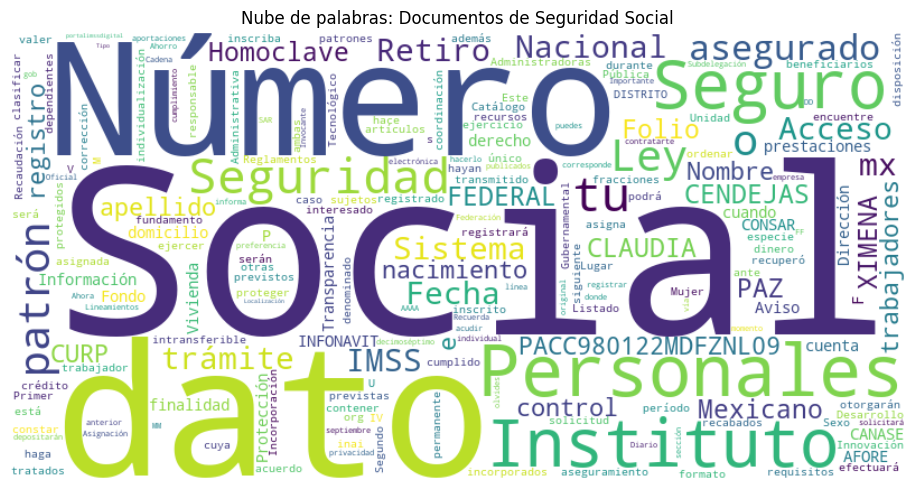

☁️ Generando nube de palabras para: Trabajos Académicos y Viajes


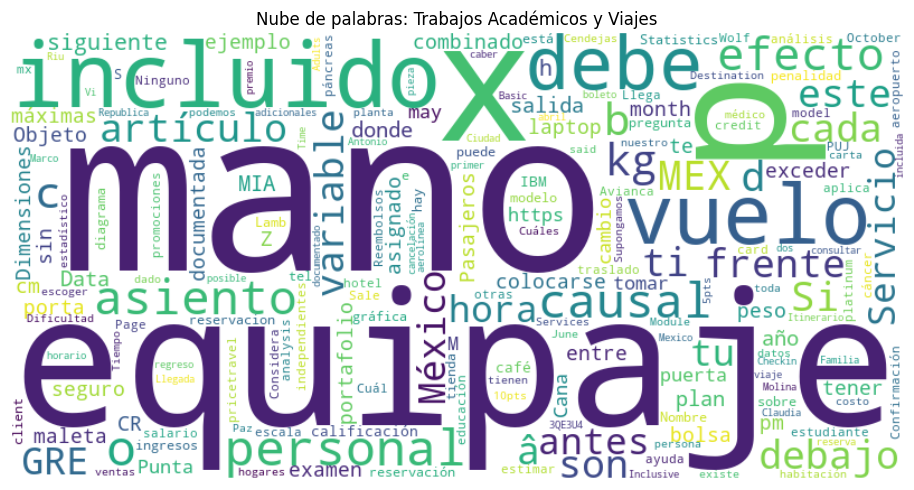

☁️ Generando nube de palabras para: Inteligencia Artificial y PLN


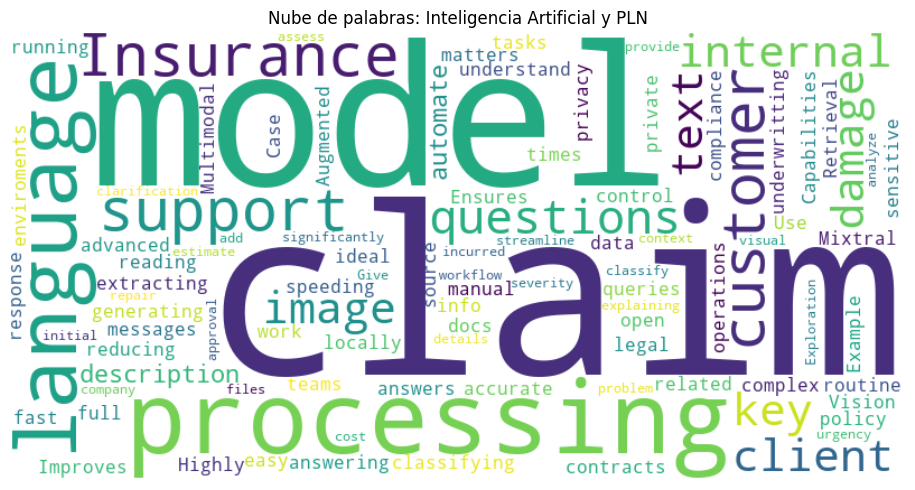

☁️ Generando nube de palabras para: Varios Código Literatura Gráficos


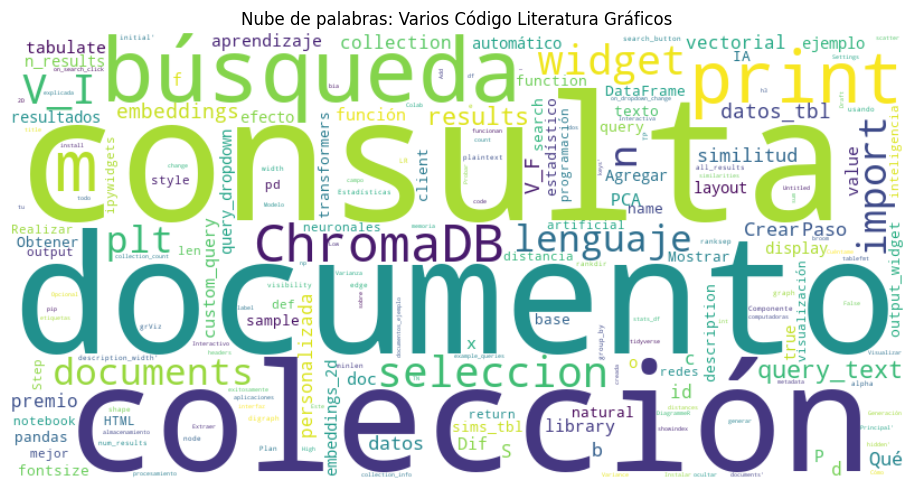

☁️ Generando nube de palabras para: Análisis y Estadística


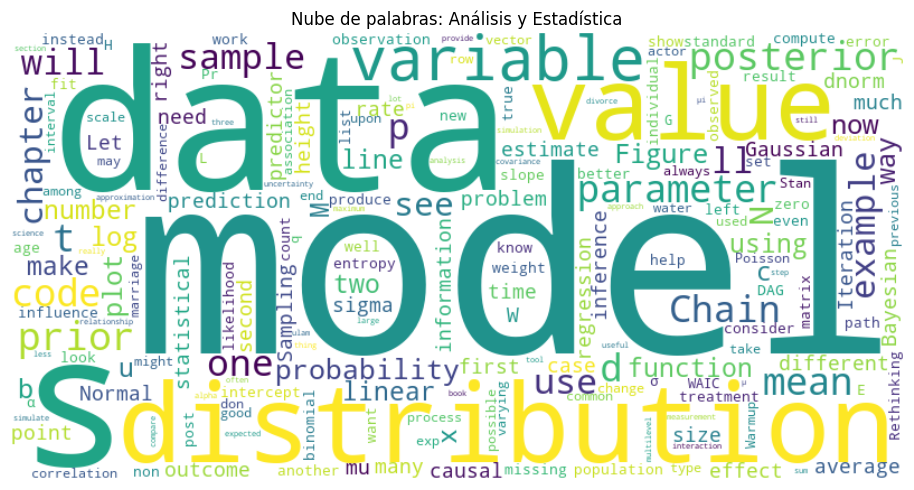

In [7]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Crear lista personalizada de stopwords en español
stopwords_es = set(STOPWORDS)
stopwords_es.update([
    "de", "la", "el", "en", "y", "que", "por", "para", "con", "una", "un",
    "del", "al", "se", "es", "lo", "las", "los", "su", "sus", "a", "como", "más",
    "también", "esto", "eso", "ya", "pero", "sí", "no", "fue", "ha", "han"
])

# Generar nube por tema
for tema in df["Tema"].unique():
    print(f"☁️ Generando nube de palabras para: {tema}")
    textos_del_tema = [
        extraer_texto(a) for a, t in zip(archivos_validos, etiquetas) if t.replace("_", " ") == tema
    ]
    texto_unido = " ".join(textos_del_tema)

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=stopwords_es,
        collocations=False
    ).generate(texto_unido)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Nube de palabras: {tema}")
    plt.tight_layout()
    plt.show()


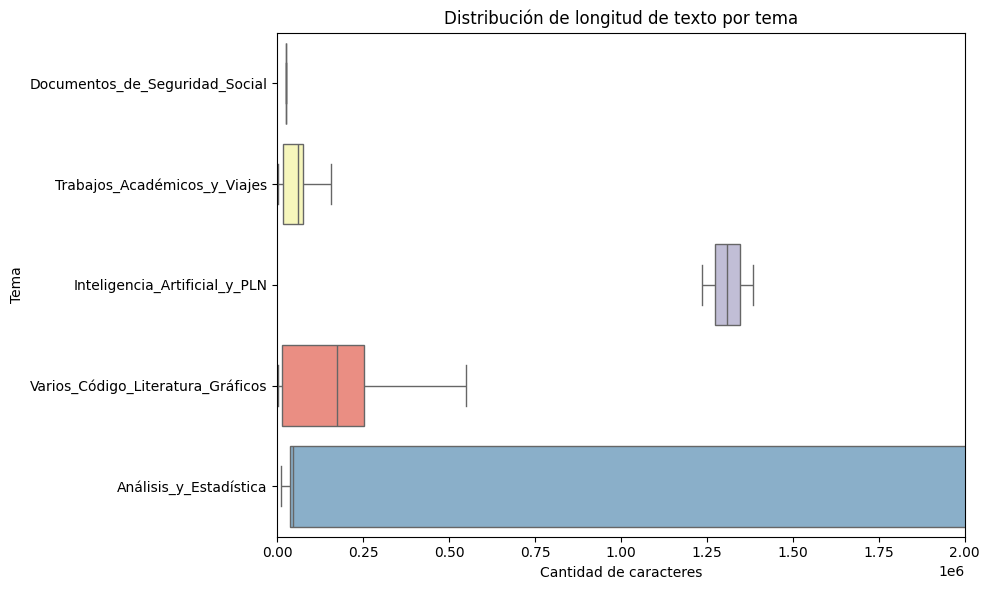

In [8]:
archivos = [str(r) for r in Path(RUTA_CARPETA).rglob("*") if r.is_file()]

def leer_texto_simple(archivo):
    try:
        with open(archivo, 'r', encoding='utf-8', errors='ignore') as f:
            return f.read()
    except:
        return ""

textos = [leer_texto_simple(a) for a in archivos]


archivos_filtrados = [a for a in archivos if Path(a).parent.name != "mis_archivos"]
textos_filtrados = [t for a, t in zip(archivos, textos) if Path(a).parent.name != "mis_archivos"]

# ✅ Crea el DataFrame limpio
df = pd.DataFrame({
    "Archivo": [os.path.basename(a) for a in archivos_filtrados],
    "Tema": [Path(a).parent.name for a in archivos_filtrados],
    "Texto": textos_filtrados
})

df["Longitud_texto"] = df["Texto"].str.len()

# 🎨 Gráfica
import matplotlib.pyplot as plt
import seaborn as sns

# 📊 Gráfica
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Longitud_texto", y="Tema", palette="Set3")
plt.xlim(0, 2000000)
plt.title("Distribución de longitud de texto por tema")
plt.xlabel("Cantidad de caracteres")
plt.ylabel("Tema")
plt.tight_layout()
plt.show()

# Conclusiones

El sistema desarrollado demuestra cómo es posible aplicar técnicas de inteligencia artificial y procesamiento de lenguaje natural para automatizar de manera eficiente la clasificación de archivos. A través de una arquitectura basada en extracción de texto multiformato, generación de embeddings semánticos y agrupamiento no supervisado, se logra organizar documentos por su contenido real, sin depender de nombres de archivo, extensiones o carpetas manuales.

Una de las principales fortalezas del sistema es que no requiere intervención humana directa para etiquetar o categorizar documentos. A diferencia de otros métodos tradicionales de organización, este enfoque es semántico, es decir, comprende el significado profundo del texto y lo utiliza para tomar decisiones más precisas. Esto es particularmente útil en entornos donde se manejan grandes volúmenes de información de múltiples fuentes y tipos: documentos legales, informes técnicos, material académico, reportes de datos, entre otros.

Además, gracias a la integración con modelos como GPT-4, el sistema es capaz de analizar el contenido agrupado, proponer nombres temáticos más adecuados, detectar errores de clasificación y corregirlos automáticamente. Incluso se incorporan agentes "juzgadores" para revisar casos ambiguos, reforzando la solidez del proceso.

# Mejoras futuras

Si bien el sistema ya funciona de manera robusta, existen varias líneas de mejora y expansión que podrían implementarse:

-Detección automática del número óptimo de clusters: Actualmente el número de grupos debe definirse manualmente. Incorporar métodos como el codo de Elbow, la silueta o técnicas bayesianas permitiría determinar dinámicamente la cantidad ideal de temas latentes.

- Interfaz gráfica o panel interactivo: Desarrollar una visualización interactiva tipo dashboard (por ejemplo, con Streamlit o Dash) permitiría al usuario revisar, modificar y explorar los clusters de forma más intuitiva.

- Mejora en el manejo de archivos no textuales o corruptos: Si bien se implementan filtros para archivos vacíos, se podría expandir la capacidad de extracción a archivos más complejos como archivos ZIP, correos electrónicos, imágenes escaneadas con baja calidad, etc.
Integración con sistemas de almacenamiento en la nube (Google Drive, S3, etc.): Para facilitar su uso en entornos empresariales y colaborativos.